## 1D Diffusion with Spatial Dependence - Heterogenous Media
Numerical Method : *py-pde* solver. <br>
Code taken from [this tutorial](https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_heterogeneous_diffusion.html). <br>
```
u_tt = D_x*u_x + D*u_xx   on [-5,5] in the x-axis and [0,10] in time
```

Dirichlet Boundary Conditions : 
```
u=0
```

Diffusion Dependence :
```
 D = 2.22 + 2*tanh(x) 
```

InitialCondition : 
```
u(x,t=0) = 1

```


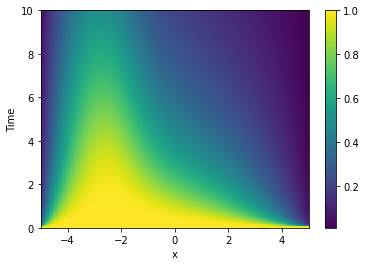

In [ ]:
! pip install py-pde  
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph

# Expanded definition of the PDE
diffusivity = "2.22 + 2*tanh(x)"
term_1 = f"({diffusivity}) * laplace(c)"
term_2 = f"dot(gradient({diffusivity}), gradient(c))"
eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})

grid_length = 64
grid = CartesianGrid([[-5, 5]], 64)  # generate grid
field = ScalarField(grid, 1)  # generate initial condition

storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, 10, dt=1e-3, tracker=storage.tracker(0.1))  # solve the PDE

plot_kymograph(storage)  # visualize the result in a space-time plot


x = np.linspace(-5, 5, 64)
t = np.linspace(0, 10, 101)
D = 2.22 + 2*np.tanh(x)
u_sol = np.asarray(storage.data)

Diffusion = lambda x: 2.22 + 2*np.tanh(x)

In [ ]:
import os
import time
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline


!pip install pyDOE
from pyDOE import lhs
import torch
import torch.nn as nn

# %
default_device = "cuda" if torch.cuda.is_available() else "cpu"

dtype=torch.float32
torch.set_default_dtype(dtype)

def torch_tensor_grad(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = True
    return x 

def torch_tensor_nograd(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = False
    return x 


In [ ]:
# Setting the random seed. 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
#Setting up a Resnet as the PINN. 
class Resnet(nn.Module):
    def __init__(self, in_features, out_features, num_neurons, activation=torch.sin):
        super(Resnet, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.num_neurons = num_neurons
        
        self.act_func = activation
        
        self.block1_layer1 = nn.Linear(self.in_features, self.num_neurons)
        self.block1_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block1 = [self.block1_layer1, self.block1_layer2]
        
        self.block2_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block2_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block2 = [self.block2_layer1, self.block2_layer2]
        
        # self.block3_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block3_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block3 = [self.block3_layer1, self.block3_layer2]
        
        # self.block4_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block4_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block4 = [self.block4_layer1, self.block4_layer2]
        
        self.layer_after_block = nn.Linear(self.num_neurons + self.in_features, self.num_neurons)
        self.layer_output = nn.Linear(self.num_neurons, self.out_features)
        
        
    def forward(self, x):
        
        x_temp = x
        
        for dense in self.block1:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block2:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block3:
        #    x_temp = self.act_func(dense(x_temp))           
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block4:
        #    x_temp = self.act_func(dense(x_temp))
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        x_temp = self.act_func(self.layer_after_block(x_temp))
        x_temp = self.layer_output(x_temp)
        return x_temp

#Setting up a derivative function that goes through the graph and calculates via chain rule the derivative of u wrt x 
deriv = lambda u, x: torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]


In [ ]:
#Setting up an instance of the Resnet with the needed architecture. 
npde_net = Resnet(2, 1, 100)
npde_net = npde_net.to(default_device)


In [ ]:
! pip install pyDOE
from pyDOE import lhs

#Specifying the Domain of Interest. 
x_range = [-5.0, 5.0]
t_range = [0.0, 10.0]
Diffusion = lambda x: 2.22 + 2*torch.tanh(x)

lb = np.asarray([x_range[0], t_range[0]])
ub = np.asarray([x_range[1], t_range[1]])

def LHS_Sampling(N):
    return lb + (ub-lb)*lhs(2, N)


In [ ]:
#Domain Loss Function - measuring the deviation from the PDE functional. 

def pde(X):

    x = X[:, 0:1]
    t = X[:, 1:2]

    u = npde_net(torch.cat([x,t],1))

    u_x = deriv(u, x)
    u_xx = deriv(u_x, x)

    D = Diffusion(x)
    D_x = deriv(D, x)

    u_t = deriv(u, t)
    
    pde_loss = u_t - D_x*u_x - D*u_xx

    return pde_loss.pow(2).mean()




#Boundary Loss Function - measuring the deviation from boundary conditions for f(x_lim, y_lim, t)
def boundary(X):

    u = npde_net(X)
    bc_loss = u - 0 

    return bc_loss.pow(2).mean()


#Reconstruction Loss Function - measuring the deviation fromt the actual output. Used to calculate the initial loss
def reconstruction(X, Y):
    u = npde_net(X)
    recon_loss = u-Y
    return recon_loss.pow(2).mean()


In [ ]:
#Normalisation Strategies
def min_max_norm(x):
    return 2*(x-np.min(x))/(np.max(x)-np.min(x)) - 1

def z_score(x):
    return (x-np.mean(x)) / np.std(x)

def identity(x):
  return x


In [ ]:
#Samples taken from each region for optimisation purposes. 
N_i = 64
N_b = 100
N_f = 50000

In [ ]:
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) 
u_star = u_sol.flatten()[:,None]              



In [ ]:
# Data for Initial Input 

X_IC = np.hstack((X[0:1,:].T, T[0:1,:].T))

u_IC = u_sol[0].flatten()
u_IC = np.expand_dims(u_IC, 1)

idx = np.random.choice(X_IC.shape[0], N_i, replace=False) 
X_i = X_IC[idx]
u_i = u_IC[idx]

In [ ]:
# Data for Boundary Input

X_left = LHS_Sampling(N_b)
X_left[:,0:1] = x_range[0]

X_right = LHS_Sampling(N_b)
X_right[:,0:1] = x_range[1]

X_b = np.vstack((X_left, X_right))
np.random.shuffle(X_b) 

In [ ]:
#Data for Domain Input
X_f = LHS_Sampling(N_f)


In [ ]:
#Converting to tensors 

X_i = torch_tensor_grad(X_i)
Y_i = torch_tensor_nograd(u_i)
X_b = torch_tensor_grad(X_b)
X_f = torch_tensor_grad(X_f)

Streaming output truncated to the last 5000 lines.
It: 5001, Init: 6.521e-05, Bound: 3.850e-05, Domain: 1.328e-04
It: 5002, Init: 3.972e-05, Bound: 1.637e-05, Domain: 7.566e-05
It: 5003, Init: 7.652e-06, Bound: 5.411e-06, Domain: 2.747e-05
It: 5004, Init: 2.004e-05, Bound: 1.145e-05, Domain: 7.573e-05
It: 5005, Init: 4.694e-05, Bound: 1.796e-05, Domain: 1.087e-04
It: 5006, Init: 3.370e-05, Bound: 2.009e-05, Domain: 5.474e-05
It: 5007, Init: 1.203e-05, Bound: 7.348e-06, Domain: 2.825e-05
It: 5008, Init: 1.192e-05, Bound: 2.154e-06, Domain: 6.364e-05
It: 5009, Init: 2.198e-05, Bound: 9.638e-06, Domain: 8.061e-05
It: 5010, Init: 2.518e-05, Bound: 1.186e-05, Domain: 5.083e-05
It: 5011, Init: 1.331e-05, Bound: 9.793e-06, Domain: 2.703e-05
It: 5012, Init: 8.281e-06, Bound: 4.307e-06, Domain: 4.746e-05
It: 5013, Init: 1.355e-05, Bound: 1.927e-06, Domain: 6.741e-05
It: 5014, Init: 1.510e-05, Bound: 6.697e-06, Domain: 4.762e-05
It: 5015, Init: 1.263e-05, Bound: 8.152e-06, Domain: 2.635e-05
It: 

Text(0, 0.5, 'L2 Error')

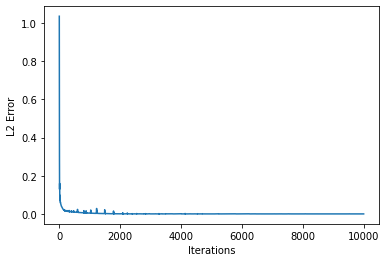

In [ ]:
#Training Loop
optimizer = torch.optim.Adam(npde_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)

it=0
epochs = 10000
loss_list = []

start_time = time.time()
while it < epochs :
    optimizer.zero_grad()

    initial_loss = reconstruction(X_i, Y_i) 
    boundary_loss = boundary(X_b)
    domain_loss = pde(X_f)

    loss = initial_loss + boundary_loss + domain_loss   
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    it += 1

    print('It: %d, Init: %.3e, Bound: %.3e, Domain: %.3e' % (it, initial_loss.item(), boundary_loss.item(), domain_loss.item()))


train_time = time.time() - start_time
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('L2 Error')

In [ ]:
#Getting the trained output. 
if default_device == 'cpu':
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).detach().numpy()

else : 
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).cpu().detach().numpy()
        
l2_error = np.mean((u_star - u_pred)**2)

u_pred = u_pred.reshape(len(u_sol), grid_length)


In [ ]:
print('Training Time: %d seconds, L2 Error: %.3e' % (train_time, l2_error))


Training Time: 980 seconds, L2 Error: 2.321e-03


In [ ]:
def plot_kymograph(name, u):
  extent = [lb[0], ub[0], lb[1], ub[1]]
  plt.figure()
  plt.imshow(np.flip(u, 0), extent=extent)
  extent = [(lb[0], ub[0], lb[1], ub[1])]
  plt.xlabel('x')
  plt.ylabel('Time')
  plt.title(name)


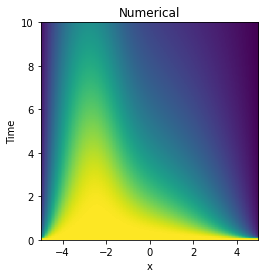

In [ ]:
plot_kymograph('Numerical', u_sol)


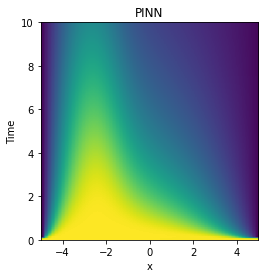

In [ ]:
plot_kymograph('PINN', u_pred)


In [ ]:
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML

def animate(data):
  fig = plt.figure()
  camera = Camera(fig)
  for ii in range(len(data)):
      plt.plot(data[ii])
      camera.snap()
  animation = camera.animate()

  return animation


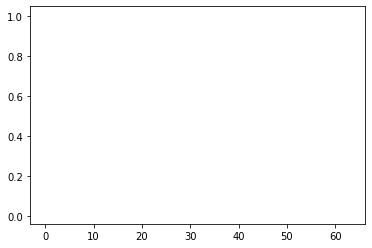

In [ ]:
animation = animate(u_sol)
HTML(animation.to_html5_video())


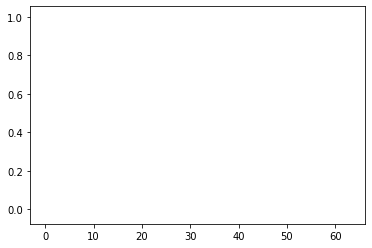

In [ ]:
animation = animate(u_pred)
HTML(animation.to_html5_video())